# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 


(PLOS CB / ELIFE)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id

# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "001"
TASK_RESULTS = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID)
print("Loaded the task results for " + str(len(TASK_RESULTS)) + " subjects.")

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB

Loaded the task results for 10 subjects.


## 1. Dataset composition
A few plots to show how the participants demographics compared.

Browser check : 
0    CHROME 
1    CHROME 
2    CHROME 
3    CHROME 
4    CHROME 
5    CHROME 
6    CHROME 
7    CHROME 
8    CHROME 
9     OPERA 
Name: browser, dtype: object


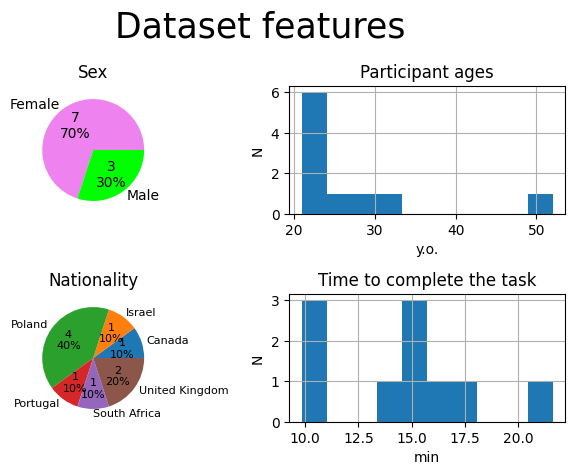

In [2]:
# Create a pandas dataframe from the list of subject dictionnaries :
list_of_dicts = [entry[0] for entry in TASK_RESULTS]
df = pd.DataFrame(list_of_dicts)

# Add the time taken recorded by the application : (a better measure than the one provided by Prolific for some reason)
df["application_measured_timetaken"] = (df["finish_date"]-df["start_date"]).dt.total_seconds()

fig, axs = plt.subplots(2, 2, dpi=100, tight_layout=True)
fig.suptitle("Dataset features",fontsize=25)
ax_sex = axs[0,0]
ax_age = axs[0,1]
ax_country = axs[1,0]
ax_time_to_complete_task = axs[1,1]


ax_sex.set_title("Sex")
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'
df.groupby('Sex').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['violet', 'lime'], ax=ax_sex)

ax_age.set_title("Participant ages")
ax_age.hist(df["Age"],bins=10)
ax_age.set_xlabel("y.o.")
ax_age.set_ylabel("N")
ax_age.grid()    

ax_country.set_title("Nationality")
df.groupby('Nationality').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, ax=ax_country)

ax_time_to_complete_task.set_title("Time to complete the task")
ax_time_to_complete_task.hist(df["application_measured_timetaken"]/60,bins=10)
ax_time_to_complete_task.set_xlabel("min")
ax_time_to_complete_task.set_ylabel("N")
ax_time_to_complete_task.grid()    

print('Browser check : ')
print(df["browser"])


## 2. Analyzing the results !

Let's start by the feedback trajectories :

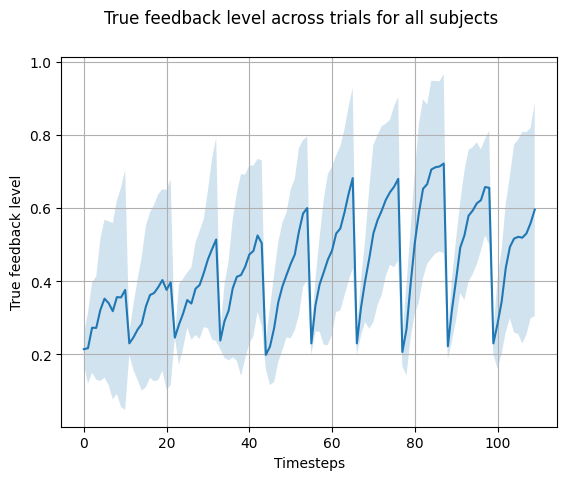

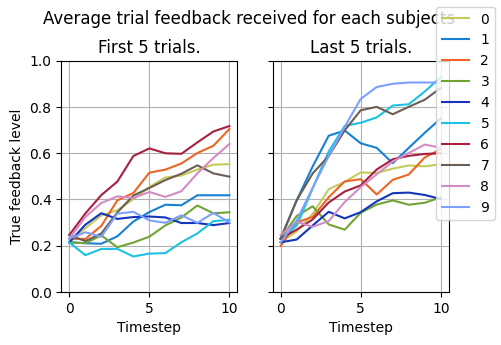

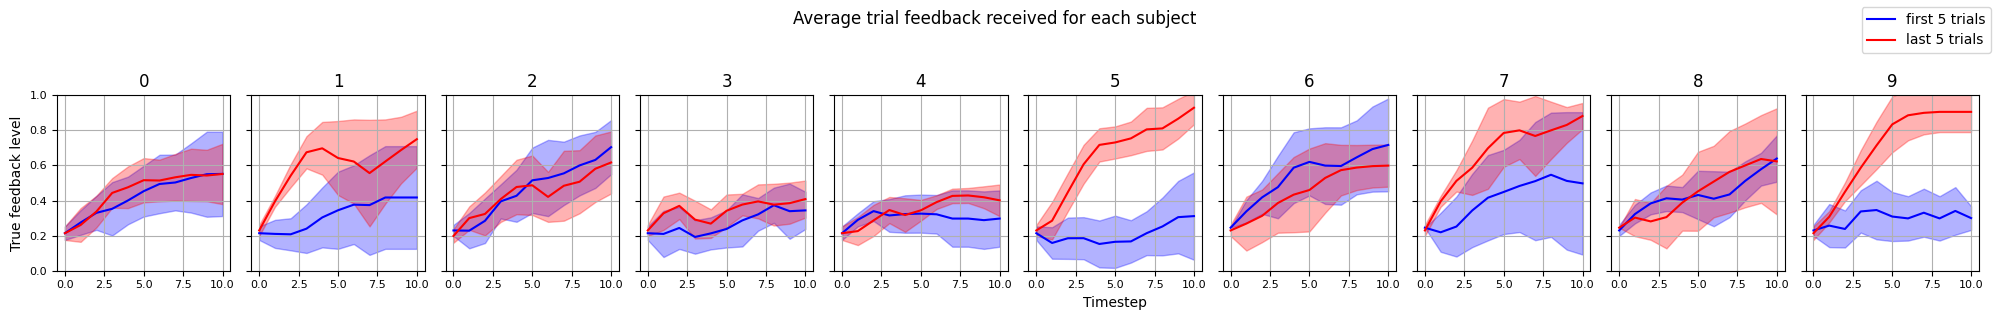

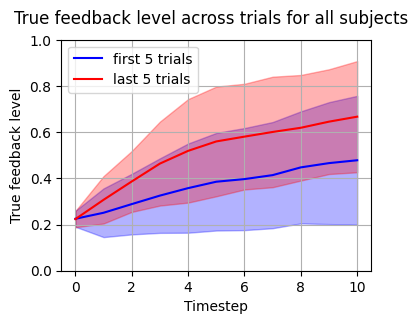

In [13]:
# Training curves : 
all_feedback_data = np.stack([subjdata[2]["scoring"]["feedback"] for subjdata in TASK_RESULTS])
true_feedback_all_subjects = np.stack([subjdata[2]["scoring"]["feedback"].flatten() for subjdata in TASK_RESULTS])

Nsubj = all_feedback_data.shape[0]
all_timesteps = np.arange(true_feedback_all_subjects.shape[-1])
one_trial_timesteps = np.arange(all_feedback_data.shape[-1])

# First and last K trials : 
K = 5
mean_first_K,std_first_K = np.mean(all_feedback_data[...,:K,:],axis=1),np.std(all_feedback_data[...,:K,:],axis=1)
mean_last_K,std_last_K = np.mean(all_feedback_data[...,-K:,:],axis=1),np.std(all_feedback_data[...,-K:,:],axis=1)

colorlist = np.random.random((Nsubj,3))
# Figures  _______________________________________________________________________________________________________
fig,ax = plt.subplots()
fig.suptitle("True feedback level across trials for all subjects")
mean_fbs = np.mean(true_feedback_all_subjects,axis=0)
std_fbs = np.std(true_feedback_all_subjects,axis=0)  # Std between all subjects
ax.plot(all_timesteps,mean_fbs)
ax.fill_between(all_timesteps,mean_fbs - std_fbs, mean_fbs + std_fbs, alpha = 0.2)
ax.set_ylabel("True feedback level")
ax.set_xlabel("Timesteps")
# ax.axvline(np.linspace(0,timesteps[-1],11))
ax.grid()


# Comparing the first K and the last K trials : 
fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True)
fig.suptitle("Average trial feedback received for each subjects",y=1.05)
for ax in axs :
    ax.set_ylim([0.0,1.0])
    ax.set_xlabel("Timestep")
    ax.grid()
axs[0].set_ylabel("True feedback level")
axs[0].set_title("First " + str(K) + " trials.") 
axs[1].set_title("Last " + str(K) + " trials.") 
for subject_data in range(mean_first_K.shape[0]):
    color = colorlist[subject_data,:]

    axs[0].plot(one_trial_timesteps,mean_first_K[subject_data,...],color=color,alpha=1,label = str(subject_data))
    # axs[0].fill_between(one_trial_timesteps,mean_first_K[subject_data,...] - std_first_K[subject_data,...], mean_first_K[subject_data,...] + std_first_K[subject_data,...],color=color, alpha = 0.2)
    
    axs[1].plot(one_trial_timesteps,mean_last_K[subject_data,...],color=color,alpha=1)
    # axs[1].fill_between(one_trial_timesteps,mean_last_K[subject_data,...] - std_last_K[subject_data,...], mean_last_K[subject_data,...] + std_last_K[subject_data,...],color=color, alpha = 0.2)
fig.legend()


# Same plot but for each subject individually :
# Comparing the first K and the last K trials : 

fig,axs = plt.subplots(1,Nsubj,sharey=True,figsize = (2*Nsubj,3))
fig.suptitle("Average trial feedback received for each subject",y=1.05)
for ax in axs :
    ax.set_ylim([0.0,1.0])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=5)
    ax.grid()
axs[0].set_ylabel("True feedback level")
axs[int(Nsubj/2)].set_xlabel("Timestep")
# axs[0].set_title("First " + str(K) + " trials.") 
# axs[1].set_title("Last " + str(K) + " trials.") 

all_feedback_data = np.stack([subjdata[2]["scoring"]["feedback"] for subjdata in TASK_RESULTS])

one_trial_timesteps = np.arange(all_feedback_data.shape[-1])
i = 0
for subject_data in range(mean_first_K.shape[0]):
    ax = axs[subject_data]
    ax.set_title(subject_data)
    color = colorlist[subject_data,:]
    ax.plot(one_trial_timesteps,mean_first_K[subject_data,...],color="blue",alpha=1,label="first " + str(K) + " trials"if i == 0 else "")
    ax.fill_between(one_trial_timesteps,mean_first_K[subject_data,...] - std_first_K[subject_data,...], mean_first_K[subject_data,...]+ std_first_K[subject_data,...],color="blue", alpha = 0.3)

    ax.plot(one_trial_timesteps,mean_last_K[subject_data,...],color="red",alpha=1,label="last " + str(K) + " trials"if i == 0 else "")
    ax.fill_between(one_trial_timesteps,mean_last_K[subject_data,...] - std_last_K[subject_data,...], mean_last_K[subject_data,...] +std_last_K[subject_data,...],color="red", alpha = 0.3)
    
    i += 1
fig.legend()
fig.tight_layout()


# Same plot, but mean across subjects : 
# Comparing the first K and the last K trials : 
fig,ax = plt.subplots(1,1,figsize=(4,3))
fig.suptitle("True feedback level across trials for all subjects")
ax.set_ylim([0.0,1.0])
ax.set_xlabel("Timestep")
ax.set_ylabel("True feedback level")
ax.grid()

mean_first_K,std_first_K = np.mean(all_feedback_data[...,:K,:],axis=(0,1)),np.std(all_feedback_data[...,:K,:],axis=(0,1))
mean_last_K,std_last_K = np.mean(all_feedback_data[...,-K:,:],axis=(0,1)),np.std(all_feedback_data[...,-K:,:],axis=(0,1))

ax.plot(one_trial_timesteps,mean_first_K,color="blue",alpha=1,label="first " + str(K) + " trials")
ax.fill_between(one_trial_timesteps,mean_first_K - std_first_K, mean_first_K+ std_first_K,color="blue", alpha = 0.3)

ax.plot(one_trial_timesteps,mean_last_K,color="red",alpha=1,label="last " + str(K) + " trials")
ax.fill_between(one_trial_timesteps,mean_last_K - std_last_K, mean_last_K +std_last_K,color="red", alpha = 0.3)
    
ax.legend()

Judging by the curves, it appears we encounter 3 broad types of subjects :
- Subjects who start the training with poor performances yet learn the correct transition rule and reach very good performances
- Subjects with nice performances from the get go, but who struggle to get better
- Subject who struggle to make sense of the feedback and don't improve

Let's now take a look at the actions performed : 

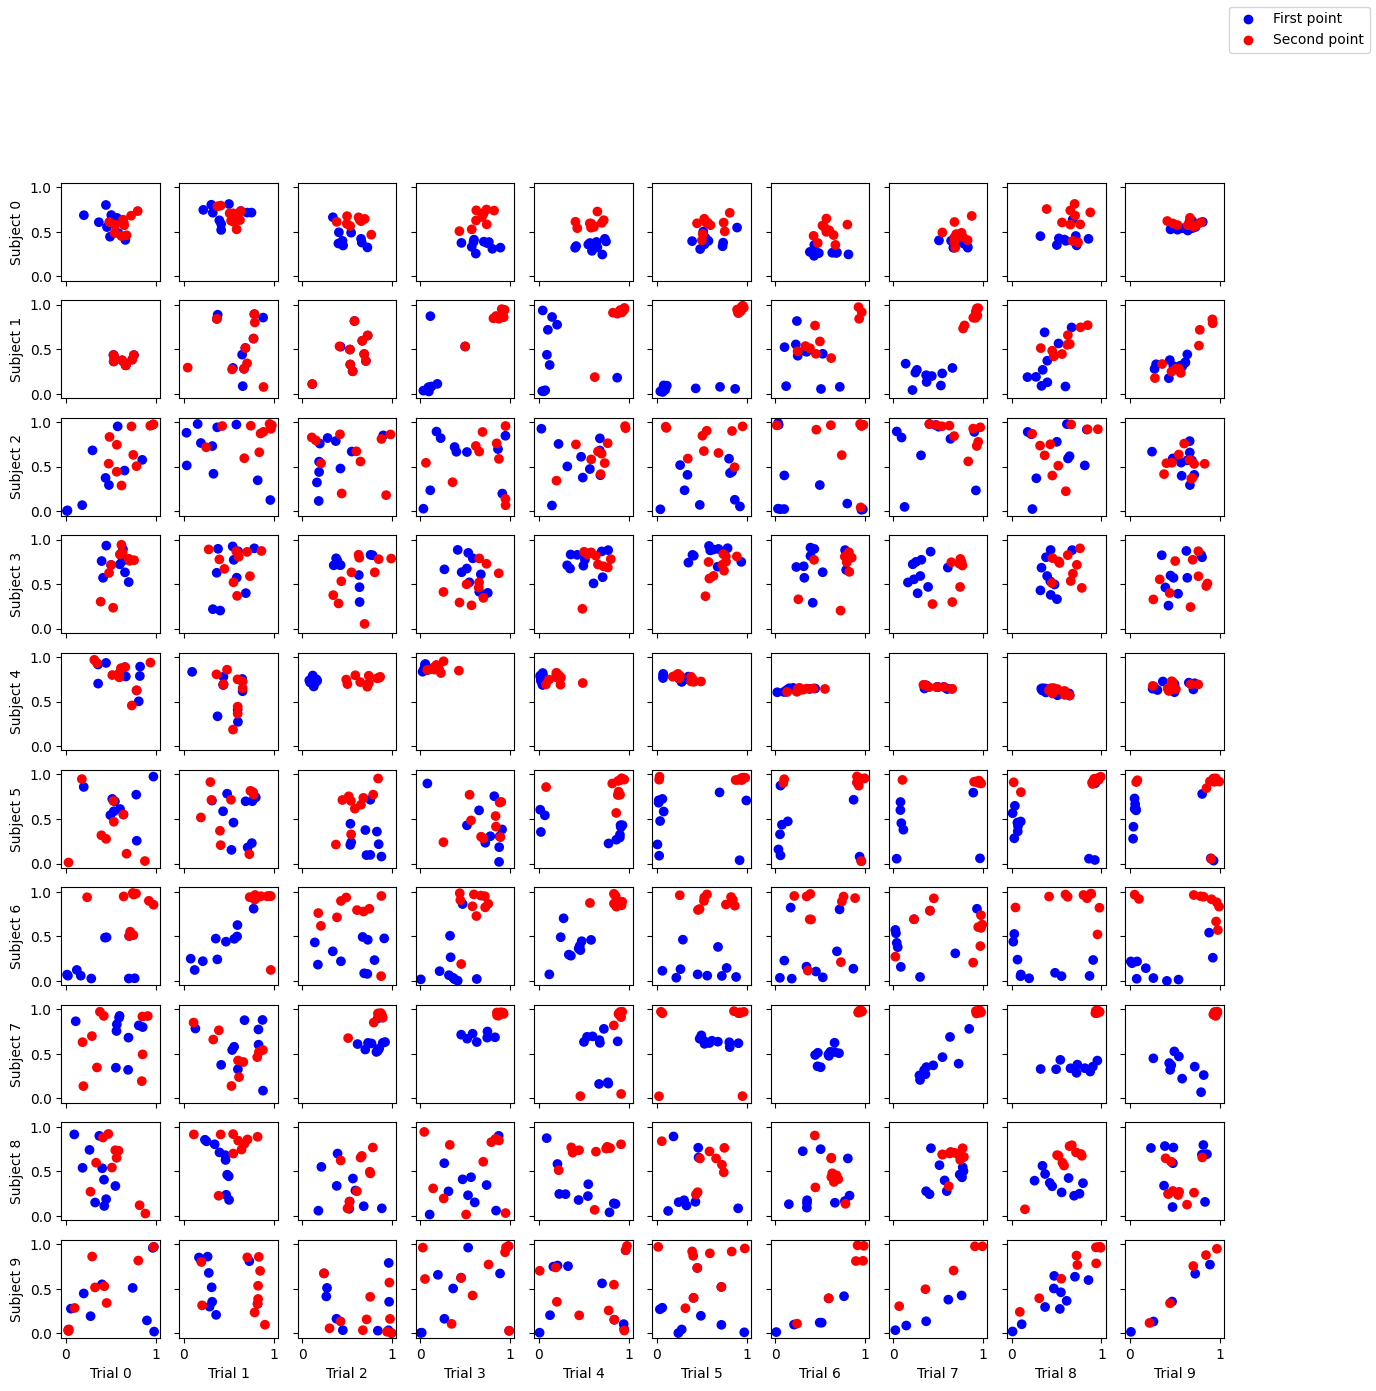

In [4]:
# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"]
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape

# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]

fig,axes = plt.subplots(Nsubj,Ntrials,sharex=True,sharey=True,figsize=(15,15))
for subj in range(Nsubj):
    leading_ax = axes[subj,0]
    leading_ax.set_ylabel("Subject " + str(subj))
    for trial in range(Ntrials):
        ax = axes[subj,trial]
        ax.scatter(all_actions_data[subj,trial,:,0,0],all_actions_data[subj,trial,:,0,1],color="blue",alpha = all_actions_data[subj,trial,:,0,-1],label="First point")
        ax.scatter(all_actions_data[subj,trial,:,1,0],all_actions_data[subj,trial,:,1,1],color="red",alpha = all_actions_data[subj,trial,:,1,-1],label="Second point")
        
        if (subj==Nsubj-1):
            ax.set_xlabel("Trial " + str(trial))
handles, labels = ax.get_legend_handles_labels()  # Just the last one !
fig.legend(handles, labels, loc='upper right')

As one can notice, this is pretty hard to read. 

Instead, we may consider that each couple of point is the result of a weighted composition of action model hypotheses. To be clearer, each couple of point can be seen as the realization of one (or several) specific beliefs about how the feedback is controlled. One possible composition of hypotheses is :
- (H1) - The feedback may answer to where (on the grey screen) is the baricenter of the points I dropped
- (H2) - The feedback may answer to how far from one another the points are
- (H3) - The feedback may answer to where the second point is relative to the first
- (H4) - The feedback may answer to temporal elements, such as how quickly the action is performed or based on the dynamics of the gauge

Let's transform the point coordinates to fit each of those hypotheses : 

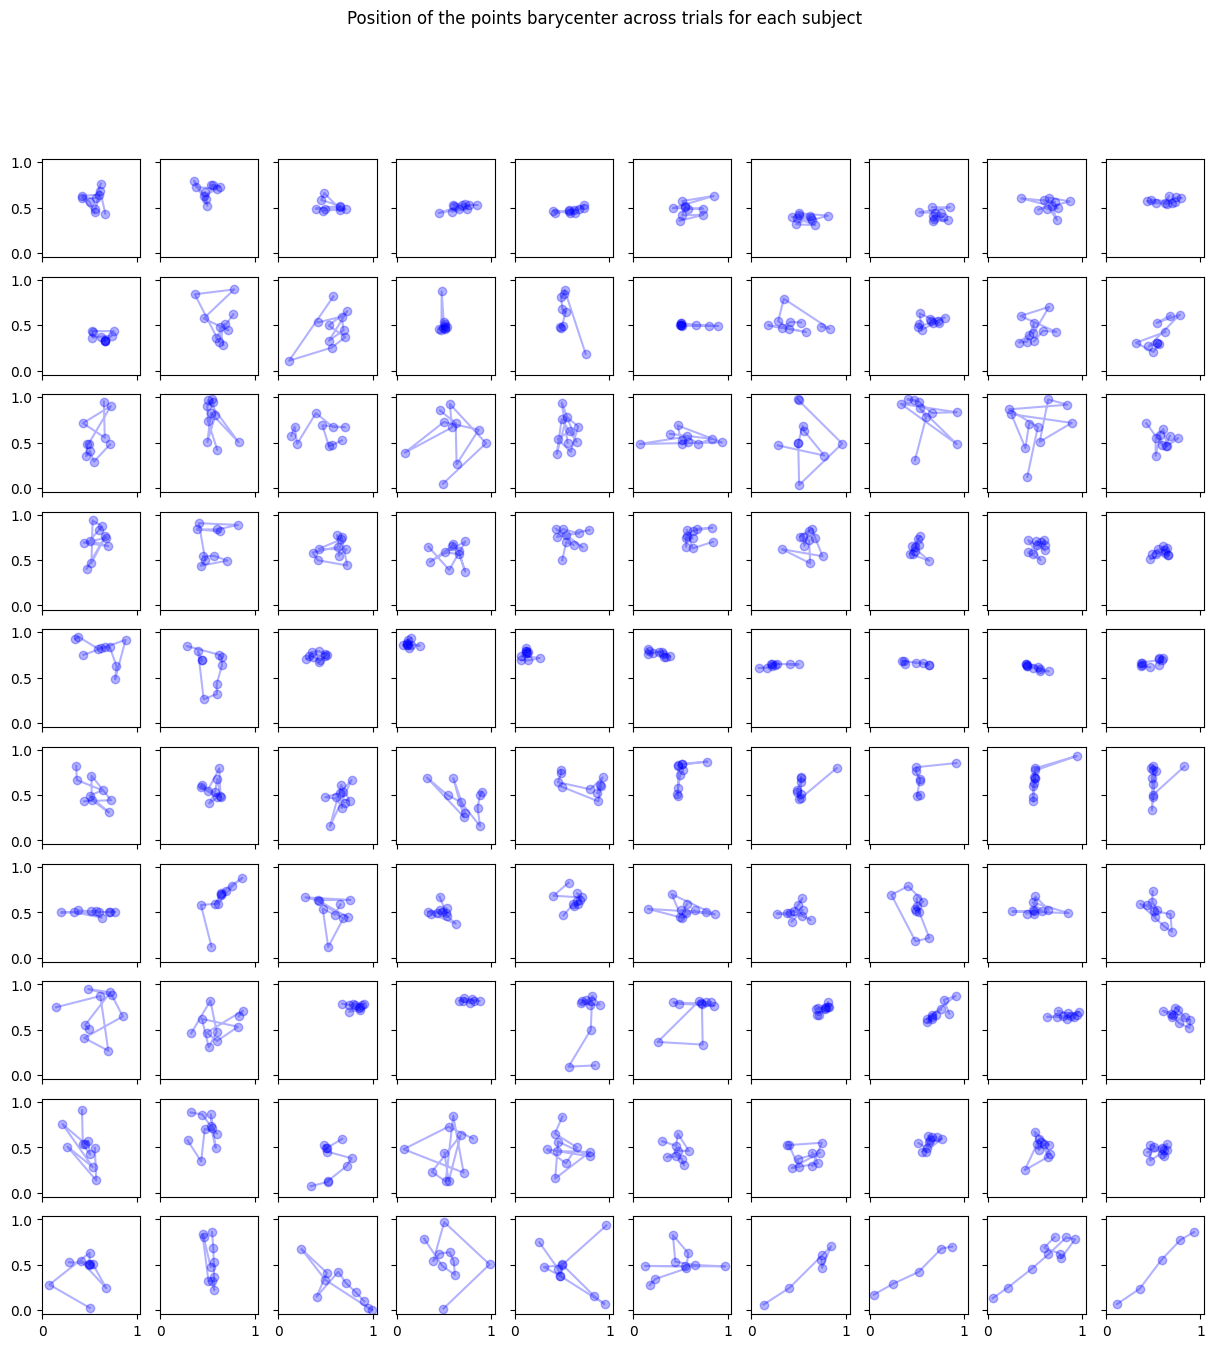

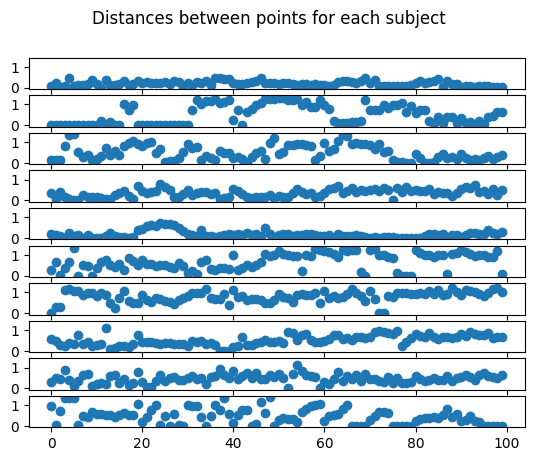

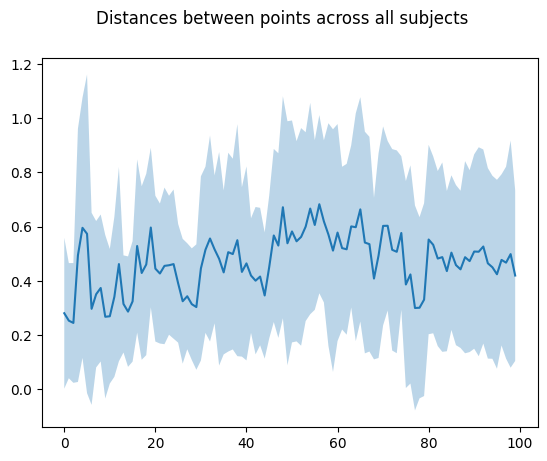

In [5]:
# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

first_point_weights = all_actions_data[...,0,-1]
second_point_weights = all_actions_data[...,1,-1]

# First, let's get the position of the barycenter for all actions. 
barycenter_x = (all_actions_data[...,0,0]*first_point_weights+all_actions_data[...,1,0]*second_point_weights)/(first_point_weights+second_point_weights+1e-10)
barycenter_y = (all_actions_data[...,0,1]*first_point_weights+all_actions_data[...,1,1]*second_point_weights)/(first_point_weights+second_point_weights+1e-10)
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)

# Plot barycenter trajectories for each subject : 
fig,axes = plt.subplots(Nsubj,Ntrials,sharex=True,sharey=True,figsize=(15,15))
fig.suptitle("Position of the points barycenter across trials for each subject")
for subj in range(Nsubj):
    for trial in range(Ntrials):
        ax = axes[subj,trial]
        
        reduced_barycenter_list = barycenters[subj,trial,...][both_points_only[subj,trial]]
        
        ax.plot(reduced_barycenter_list[:,0],reduced_barycenter_list[:,1],'o-',color="blue",alpha=0.3)

# Then, let's get the distance of both points for all actions. 
distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
# Missed actions should count as distance = 0:
distances[~both_points_only] = 0.0


# Flatten this for each subject as we want to see the curve across all trials :
distances_flat = distances.reshape((Nsubj,-1))
fig,ax = plt.subplots(Nsubj,1,sharey=True)
fig.suptitle("Distances between points for each subject")
for subj in range(Nsubj):    
    ax[subj].scatter(np.arange(distances_flat.shape[1]),distances_flat[subj,:])
    
# # Plot evolution of distances across trials for each subject : 
fig,ax = plt.subplots(1)
fig.suptitle("Distances between points across all subjects")
dist_mean = np.mean(distances_flat,axis=0)
dist_std = np.std(distances_flat,axis=0)
ax.plot(np.arange(distances_flat.shape[1]),dist_mean)#,alpha = all_actions_data[subj,trial,:,1,-1])
ax.fill_between(np.arange(distances_flat.shape[1]),dist_mean-dist_std,dist_mean+dist_std,alpha=0.3)

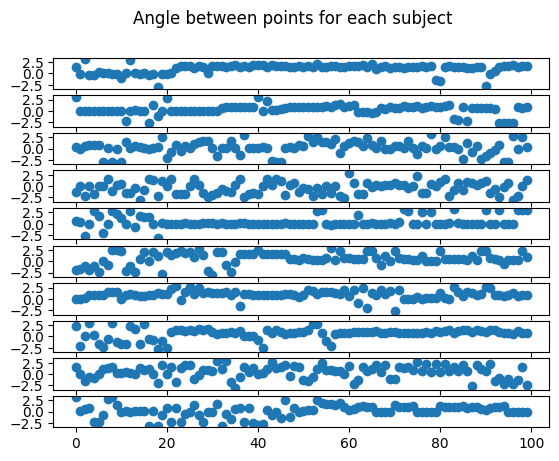

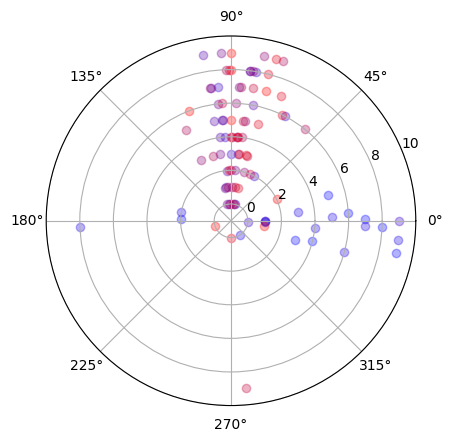

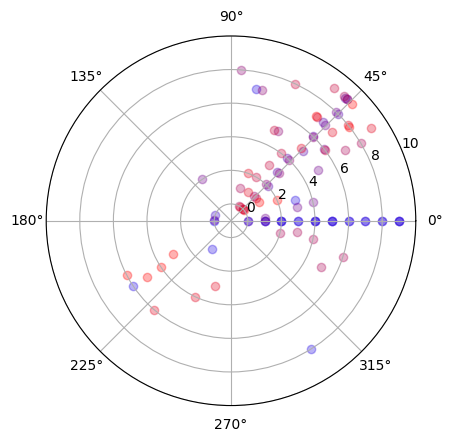

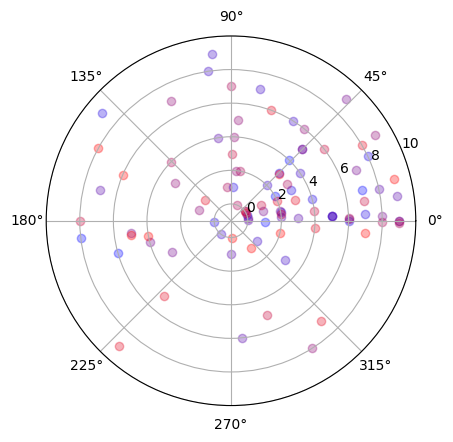

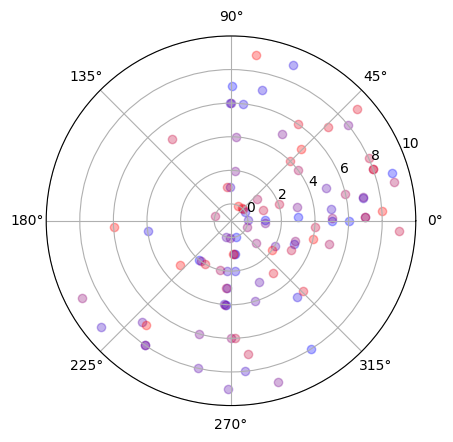

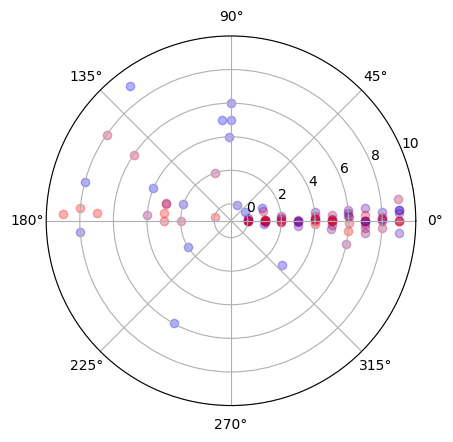

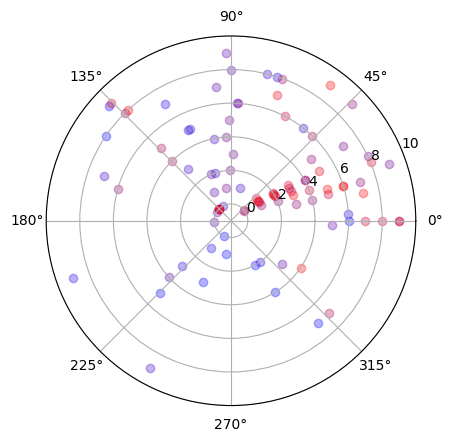

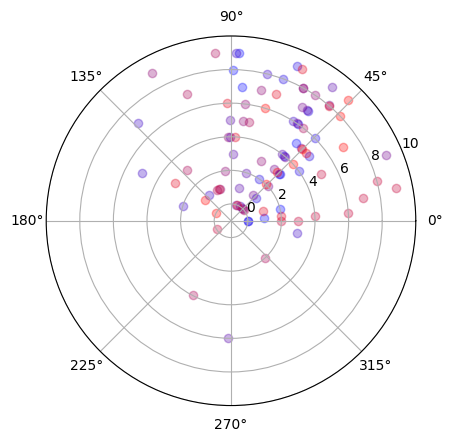

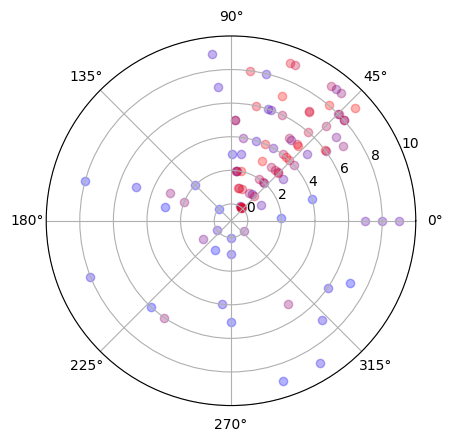

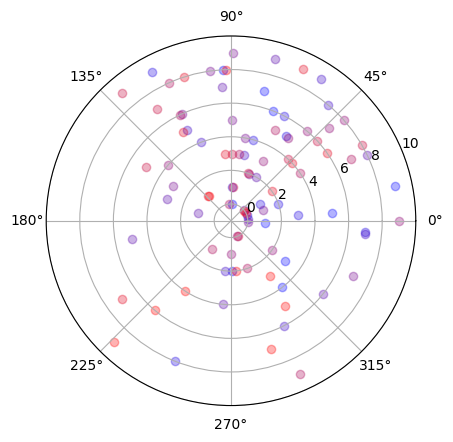

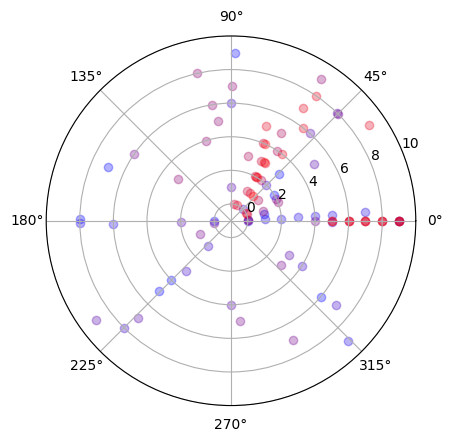

In [6]:
colors = np.linspace(np.array([0.0,0.0,1.0,1.0]),np.array([1.0,0.0,0.0,1.0]),Ntrials)


# Plot evolution of angles
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
angles_flat = angles.reshape((Nsubj,-1))
fig,ax = plt.subplots(Nsubj,1,sharey=True)
fig.suptitle("Angle between points for each subject")
for subj in range(Nsubj):    
    ax[subj].scatter(np.arange(angles_flat.shape[1]),angles_flat[subj,:])


for subj in range(Nsubj):
    fig = plt.figure()# plt.subplots(projection='polar')
    ax = fig.add_subplot(111,projection='polar')
    
    
    for trial in range(Ntrials):
        trial_vals = angles[subj,trial]
        ax.scatter(trial_vals,np.arange(trial_vals.shape[0]),color=colors[trial],alpha=0.3)
    
    ax.set_ylim(bottom  = -1,top = trial_vals.shape[0])
    
    # plt.show()

# fig = plt.figure()# plt.subplots(projection='polar')
# ax = fig.add_subplot(111,projection='polar')
# ax.set_ylim(bottom  = -1)
# # mean_angles = np.mean()
# # for subj in range(Nsubj):
    
    
# #     for trial in range(Ntrials):
# #         trial_vals = angles[subj,trial]
# #         print(trial_vals.shape)
# #         ax.scatter(trial_vals,np.arange(trial_vals.shape[0]),color=colors[trial],alpha=0.3)

In [7]:
# This is still a bit hard to read, let's plot an alternative figure ! 
# Idea : polar histogram showing counts of actions performed by the subjects, with 
# each action given a specific color : 
# array of angles, between -pi and pi
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
print(angles.shape)  # Nsubjects x Ntrials x Nactions

N_bin_categories = 32 # A multiple of 4 (or 8 !)

# The middle of the cardinal points should be the center of their respective bins
half_a_bin = (2*np.pi/(N_bin_categories))*0.5
bins = np.linspace(-np.pi + half_a_bin,np.pi - half_a_bin,N_bin_categories) 

digitized_angles = np.zeros_like(angles)
for subject in range(angles.shape[0]):
    for trial in range(angles.shape[1]):
        digitized_angles[subject,trial,:] = np.digitize(angles[subject,trial,:],bins)   
digitized_angles[digitized_angles > N_bin_categories-1] = 0
digitized_angles = digitized_angles.astype(int)

angle_counts = np.zeros((Nsubj,Ntrials,N_bin_categories))
for subject in range(angles.shape[0]):
    for trial in range(angles.shape[1]):
        angle_counts[subject,trial,:] = np.bincount(digitized_angles[subject,trial,:],minlength=N_bin_categories)

# Let's transform it into a pandas dataframe with 4 coordinates ! 
def using_multiindex(_array, columns):
    shape = _array.shape
    index = pd.MultiIndex.from_product([range(s)for s in shape], names=columns)
    df = pd.DataFrame({'Value': _array.flatten()}, index=index).reset_index()
    return df
df_digit_angles = using_multiindex(digitized_angles, ["Subject","Trial","Timestep"])
df_anglecounts = using_multiindex(angle_counts, ["Subject","Trial","Angle"])




# Plot the angles for each specific subject !
def get_fig_for_subject(subj_id,size=800):
    subject_anglecounts = df_anglecounts.loc[df_anglecounts["Subject"]==subj_id][["Trial", "Angle", "Value"]]
    subject_anglecounts["Angle_degrees"] = (subject_anglecounts["Angle"]/(N_bin_categories))*360 - 180
    fig = px.bar_polar(subject_anglecounts, r="Value", theta="Angle_degrees",
                    color="Trial", template="none",
                    labels={"Trial": "Trial when angle was input"},
                    hover_data={"Trial":True, "Value":True ,"Angle_degrees":True}
                    )

    fig.update_layout(width=size, height=size)

    PERCENT_MIDDLE = 0.30
    # maximum value for the array considered :
    max_angle_count = subject_anglecounts.groupby(['Angle'])["Value"].sum().max()
    min_val = -(PERCENT_MIDDLE/(1-PERCENT_MIDDLE))*max_angle_count

    # Adjust the layout to rotate the plot
    fig.update_layout(
        showlegend=False,
        polar=dict(
            angularaxis=dict(
                rotation=0, 
                thetaunit = "radians",
                direction = "counterclockwise"
            ),
            radialaxis = dict(
                range=[min_val,max_angle_count]
            )
        )
    )
    fig.update(layout_coloraxis_showscale=False)
    
    # fig.update_layout(
    #     margin={'t':0,'l':0,'b':0,'r':0}
    # )
    
    # fig.update_layout(legend=dict(
    #     orientation="v",
    #     yanchor="top",
    #     y=-0.1,
    #     xanchor="center",
    #     x=0.5),
    # )
    return fig


# Plot the angles for each specific subject !
def get_fig_for_all_subjects(size=800,showlegend=True):
    total_anglecounts = df_anglecounts.groupby(["Trial","Angle"])["Value"].sum()
    # total_anglecounts["Total"] = total_anglecounts["Value"].sum()
    total_anglecounts_df = total_anglecounts.reset_index()
    
    total_anglecounts_df["Angle_degrees"] = (total_anglecounts_df["Angle"]/(N_bin_categories))*360 - 180
    fig = px.bar_polar(total_anglecounts_df, r="Value", theta="Angle_degrees",
                    color="Trial", template="none",
                    labels={"Trial": "Trial when angle was input"},
                    hover_data={"Trial":True, "Value":True ,"Angle_degrees":True}
                    )

    fig.update_layout(width=size, height=size)

    PERCENT_MIDDLE = 0.30
    # maximum value for the array considered :
    max_angle_count = total_anglecounts_df.groupby(['Angle'])["Value"].sum().max()
    min_val = -(PERCENT_MIDDLE/(1-PERCENT_MIDDLE))*max_angle_count

    # Adjust the layout to rotate the plot
    fig.update_layout(
        showlegend=False,
        polar=dict(
            angularaxis=dict(
                rotation=0, 
                thetaunit = "radians",
                direction = "counterclockwise"
            ),
            radialaxis = dict(
                range=[min_val,max_angle_count]
            )
        )
    )
    fig.update(layout_coloraxis_showscale=showlegend)
    
    # fig.update_layout(
    #     margin={'t':0,'l':0,'b':0,'r':0}
    # )
    
    # fig.update_layout(legend=dict(
    #     orientation="v",
    #     yanchor="top",
    #     y=-0.1,
    #     xanchor="center",
    #     x=0.5),
    # )
    return fig

my_figure = get_fig_for_subject(0,600)
my_figure.show()

my_figure = get_fig_for_subject(1,600)
my_figure.show()


all_subjects_figure = get_fig_for_all_subjects()
all_subjects_figure.show()

(10, 10, 10)


In [8]:
# Plot the angles for all subjects !
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

figures = [get_fig_for_subject(k) for k in range(Nsubj)]


NROWS = 2
NCOLS = 5
fig = make_subplots(rows=NROWS, cols=NCOLS, specs=[[{'type': 'polar'}]*NCOLS]*NROWS,
                    horizontal_spacing = 0.0,vertical_spacing=0.1) 

for row in range(NROWS):
    for col in range(NCOLS):
        subj_id = row*NCOLS + col
        
        figure = figures[subj_id]
        for trace in range(len(figure["data"])):
            
            polar_update=dict(
                radialaxis = dict(
                    range=figure.layout["polar"]["radialaxis"]["range"]
                )
            )
            
            fig.append_trace(figure["data"][trace], row=row+1, col=col+1)
            fig.update_polars(polar_update,row=row+1,col=col+1)
            # fig.update_yaxes(range=xrange,row=row+1,col=col+1)
fig.update_layout(width=2000, height=600)
        
fig.update_layout(
        margin={'t':20,'l':0,'b':20,'r':0}
    )

fig.show()


## 3. Basic modelling : correlation between variables, statistical tests ...

                 subject_id                     task_code lang  browser  \
0  61641b8573a9dcd29ba9d87b  001+66aa3bc957ff67ef496efa0d   en  CHROME    
1  62d6d791bb6448ae52929ebd  001+66aa3bc957ff67ef496efa0d   en  CHROME    
2  5f76815c98f49612c8d1dc39  001+66aa3bc957ff67ef496efa0d   en  CHROME    
3  654108c91ce90260d7a9891c  001+66aa3bc957ff67ef496efa0d   en  CHROME    
4  654ce6c2664a6e722d69c8e0  001+66aa3bc957ff67ef496efa0d   en  CHROME    
5  603e261c7f3a46e05331f69e  001+66aa3bc957ff67ef496efa0d   en  CHROME    
6  65723bb74a071113710655e7  001+66aa3bc957ff67ef496efa0d   en  CHROME    
7  60f6b8f8e574e14634ead43e  001+66aa3bc957ff67ef496efa0d   en  CHROME    
8  6659ebda18cf5c43dbcc7354  001+66aa3bc957ff67ef496efa0d   en  CHROME    
9  61012cbdaef76ce92c412ce2  001+66aa3bc957ff67ef496efa0d   en   OPERA    

   N_trials  N_tmstps              start_date             finish_date  \
0        10        10 2024-07-31 13:39:20.537 2024-07-31 13:49:11.083   
1        10        10 2024-0

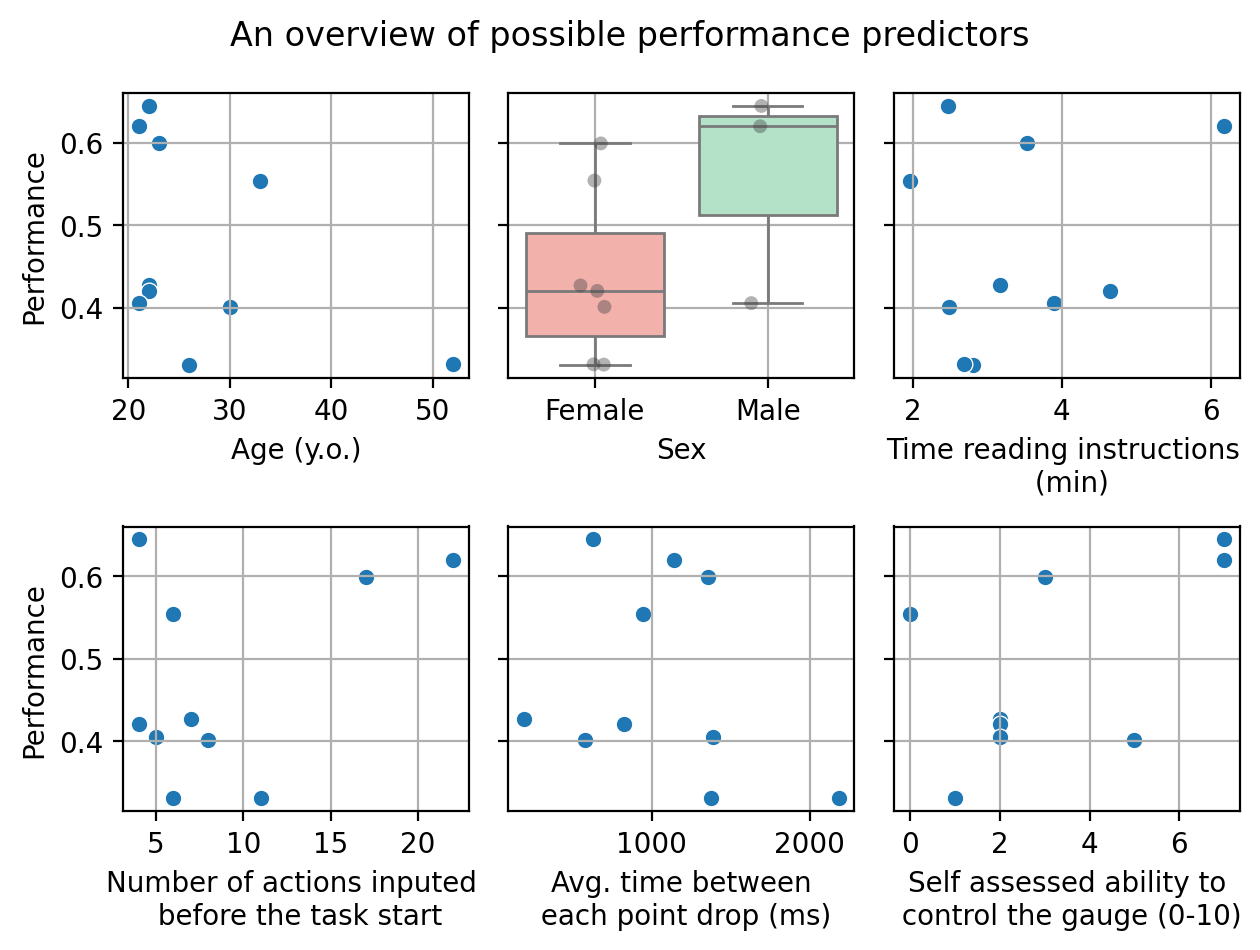

In [9]:
# Plot Age (regression), sex (histogram), time spent reading instructions (regression), number of points drawn (histogram) and average time before action (regression) vs performances of the subjects :

# First, let's get the values of interest for our subjects : 
# 1. The average (true) feedback level (over the whole training)
# 2. The average (true) feedback level (during the last K trials)

task_data = [subj_task_results[2] for subj_task_results in TASK_RESULTS] # Only get task data

# Exploring the recorded data !
# task_data_subject_0 = task_data[0]
# # We have access to trial-scale data :
# print(task_data_subject_0["scoring"]["scores"])
# print(task_data_subject_0["scoring"]["success"])
# # And timestep scale data :
# print(task_data_subject_0["scoring"]["feedback"])

feedback_for_all_subjects = np.stack([subj_data["scoring"]["feedback"] for subj_data in task_data])
# print(feedback_for_all_subjects.shape)


# What window of feedback(i.e. distance) values allows us to characterize the perofrmance of subject ?
last_k_trials = 5
last_t_timesteps = 2
feedback_all_subjs_window = feedback_for_all_subjects[:,-last_k_trials:,:-last_t_timesteps]
mean_feedback_all_subjs_last_k_trials = np.mean(feedback_all_subjs_window,axis=(-1,-2))


performance_metric = mean_feedback_all_subjs_last_k_trials



# Create a pandas dataframe from the list of subject dictionnaries :
list_of_dicts = [entry[0] for entry in TASK_RESULTS]
df = pd.DataFrame(list_of_dicts)
df["Performance"] = performance_metric.tolist()

# Get subject personnal data !
fig,axes = plt.subplots(2,3,sharey=True,dpi=200)
fig.suptitle("An overview of possible performance predictors")

# 1. Ages !
ax1 = axes[0,0]
sns.scatterplot(ax=ax1, data=df,
                x="Age", y="Performance")
ax1.set_xlabel("Age (y.o.)")
ax1.grid()

# 2. Sexes !
sexes = [subj_task_results[0]["Sex"] for subj_task_results in TASK_RESULTS]
ax2 = axes[0,1]
sns.boxplot(ax = ax2, x="Sex", y="Performance", hue="Sex",
                data=df,palette=["#FFA7A0", "#ABEAC9"],dodge=False)
sns.stripplot(ax=ax2 , x="Sex", y="Performance", 
                hue="Sex",data=df,palette=["#404040","#404040"], 
                alpha=0.4, dodge=False)
ax2.grid()

# 3. Time spent reading the instructions 
ax3 = axes[0,2]

instr_all_subj = [subj_task_results[1]["instructions"] for subj_task_results in TASK_RESULTS]
t_starts = [[evt["t"] for evt in instr if evt["val"]=="start_instructions" ] for instr in instr_all_subj]
t_ends = [[evt["t"] for evt in instr if evt["val"]=="end_instructions" ] for instr in instr_all_subj]
delta_ts = [(end[0]-start[0])/(60*1000.0) for (end,start) in zip(t_ends,t_starts)]
df["TimeReadingInstructions"] = delta_ts
sns.scatterplot(ax=ax3, data=df,
                x="TimeReadingInstructions", y="Performance")
ax3.grid()
ax3.set_xlabel("Time reading instructions \n (min)")

# 4. Numver of points dropped on the trial action screen
ax4 = axes[1,0]
df["N_actions_tested"] = [len(try_points) for try_points in df["canvas_explore_points"].values]
sns.scatterplot(ax=ax4, data=df,
                x="N_actions_tested", y="Performance")
ax4.grid()
ax4.set_xlabel("Number of actions inputed \n before the task start")

# 5. Average time between the two points !
ax5 = axes[1,1]

actions_for_all_subjects = np.stack([subj_data["blanket"]["actions"] for subj_data in task_data])
all_action_delays = actions_for_all_subjects[...,-1,2]
unfit_actions = (all_action_delays<10)
mean_of_action_delays_for_each_subjects = np.nanmean(np.where(all_action_delays>10, all_action_delays, np.nan), axis=(-1,-2))
df["Time_between_points"] = mean_of_action_delays_for_each_subjects.tolist()
sns.scatterplot(ax=ax5, data=df,
                x="Time_between_points", y="Performance")
ax5.set_xlabel("Avg. time between\n each point drop (ms)")
ax5.grid()

# 6. Self assessment at the end of the task
ax6 = axes[1,2]
sns.scatterplot(ax=ax6, data=df,
                x="mandatory_q1", y="Performance")
ax6.set_xlabel("Self assessed ability to\n control the gauge (0-10)")
ax6.grid()

print(df)
fig.tight_layout()


Possible next steps : 
- Linear models (ANCOVA) of : performance ~ Age + Sex + TimeReadingInstr + NumberOfTestedActions ?
- More predictive models, to compare to usual Neurofeedback predictors :D
- More interesting variables : 
    - Time between feedback gauge update end & first action point
    - Ability to correctly predict the effect of ones' action
    - Employment / Student status

## ANNEX : SUBJECT ANSWERS ON STRATEGY AND TASK DESIGN

In [10]:
# Warning, the questions asked may vary based on the task ID !
print("According to you, what was the best strategy in order to control the gauge level ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["mandatory_q2"])
    # print("-> " + subject_dict["Nationality"])
print()
print("Did you notice any technical issues (buttons not working, graphical bugs, etc.) ? If yes, how did they appear ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q1"])
print() 
print("How clear did you find the instructions ? What would you change to make them clearer ?")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q2"])
print() 
print("Other remarks . How hard / frustrating did you find the task ? etc.")
print("__________________________________________________________________________")
for subject_results in TASK_RESULTS:
    subject_dict,trial_data,events,fb_rtv = subject_results
    print("-> " + subject_dict["optional_q3"])
print() 

According to you, what was the best strategy in order to control the gauge level ?
__________________________________________________________________________
-> just be as quick as possible  [TRANSLATED FROM ORIGINAL : just be as quick as possible
 ]
-> I don't really understand what was going on if I'm honest
-> My strategy was to try to understand why it went up or down and change my response accordingly  [TRANSLATED FROM ORIGINAL : האסטרטגיה שלי הייתה לנסות להבין למה זה עולה או ירד ולשנות בהתאם את התגובה שלי ]
-> Honestly, I don't know. I tried the strategy of clicking once, and then waiting a certain amount of time before I clicked it again, that didn't work. I tried the strategy of clicking the grey box close together, that didn't work. I tried the strategy of clicking the gray box far apart, didn't really work. 
-> Tried clicking when the level was highest
-> Place the first point at the current level and place the second point high across the board.
-> find out what direction a 